In [1]:
import os
import pandas as pd
import datetime

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import importlib


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import callbacks  

# project specific
from utils import data_handler
from utils.models import LSTM



import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go



%load_ext tensorboard
!rm -rf ../workfiles/logs/

In [2]:
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session

sgdc_params = {
            #'penalty':["elasticnet", "l1", "l2"],
            'penalty':["l1"],
            #'l1_ratio':np.linspace(0.1, 1, 5),
            'alpha':np.linspace(0.1, 0.5, 5),
        }

x_train, filenames, n_genes = data_handler.generate_dataset(feature_selection_threshold = 2, 
                                                   #feature_selection_proceedure = "LASSO", 
                                                   retain_phases="Both", 
                                                   #retain_phases=None, 
                                                   return_id = True,
                                                   sgdc_params = sgdc_params,
                                                   #subsample = 100,
                                                   #class_balancing = "match_smaller_sample")
                                                   class_balancing = "balanced",
                                                   as_time_series = True)


Retaining patients that are included in phases 1 & 2
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 1455 samples
selecting genes based on median absolute deviation threshold:  2 ...
number of genes selected :  12121
normalizing data...
normalization done
number of seq in the dataset : 1455
converting samples to time series
number of actual individual to be studied : 291


In [3]:
importlib.reload(LSTM) # to allow modification of the script without restarting the whole session

latent_dim = 32
sequence_length = 5
t_shape = (sequence_length, n_genes)


autoencoder = LSTM.generate_model(t_shape, latent_dim)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [4]:
checkpoint_filepath = '../workfiles/simple_ae/checkpoint'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)


reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=25, min_lr=0.00001)

early_stopping_callback = callbacks.EarlyStopping(monitor='loss', patience=50)


log_dir = "../workfiles/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cb = [model_checkpoint_callback, 
      reduce_lr, 
      early_stopping_callback, 
      tensorboard_callback]

In [5]:
#%tensorboard --logdir ../workfiles/logs/fit

In [6]:
hist = autoencoder.fit(x_train, epochs=200, callbacks=cb)

Epoch 1/200


2023-08-10 15:52:45.310872: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


5/5 [==============================] - 4s 259ms/step - loss: 7.0026e-05 - lr: 0.0010
Epoch 2/200
5/5 [==============================] - 1s 281ms/step - loss: 3.2928e-05 - lr: 0.0010
Epoch 3/200
5/5 [==============================] - 1s 206ms/step - loss: 1.9598e-05 - lr: 0.0010
Epoch 4/200
5/5 [==============================] - 1s 235ms/step - loss: 1.5648e-05 - lr: 0.0010
Epoch 5/200
5/5 [==============================] - 1s 196ms/step - loss: 1.3986e-05 - lr: 0.0010
Epoch 6/200
5/5 [==============================] - 1s 200ms/step - loss: 1.2844e-05 - lr: 0.0010
Epoch 7/200
5/5 [==============================] - 1s 195ms/step - loss: 1.2268e-05 - lr: 0.0010
Epoch 8/200
5/5 [==============================] - 1s 178ms/step - loss: 1.2079e-05 - lr: 0.0010
Epoch 9/200
5/5 [==============================] - 1s 223ms/step - loss: 1.2010e-05 - lr: 0.0010
Epoch 10/200
5/5 [==============================] - 1s 192ms/step - loss: 1.1965e-05 - lr: 0.0010
Epoch 11/200
5/5 [=======================

In [7]:
autoencoder.load_weights(checkpoint_filepath)


[6.278813089011237e-05, 3.046455094590783e-05, 1.896071080409456e-05, 1.5660154531360604e-05, 1.4053290215088055e-05, 1.2986905858269893e-05, 1.2476239135139622e-05, 1.2315730600676034e-05, 1.2252998203621246e-05, 1.2211489774927031e-05, 1.2184293154859915e-05, 1.2168989997007884e-05, 1.2160691767348908e-05, 1.2155467629781924e-05, 1.215172051161062e-05, 1.214948406413896e-05, 1.2148459973104764e-05, 1.2147961570008192e-05, 1.2147603229095694e-05, 1.2147307643317617e-05, 1.2147176676080562e-05, 1.2147131201345474e-05, 1.2147125744377263e-05, 1.2147151210228913e-05, 1.214720668940572e-05, 1.2147271263529547e-05, 1.2145023902121466e-05, 1.214513395098038e-05, 1.2144996617280412e-05, 1.2144945685577113e-05, 1.2144982974859886e-05, 1.2145020264142659e-05, 1.2145032997068483e-05, 1.2145050277467817e-05, 1.2145071195845958e-05, 1.214508756675059e-05, 1.2145103937655222e-05, 1.2145122127549257e-05, 1.2145141226937994e-05, 1.2145160326326732e-05, 1.2145178516220767e-05, 1.2145196706114803e-05,

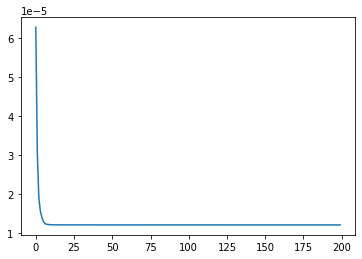

In [8]:
plt.plot(hist.history['loss'])
print(hist.history['loss'])




### some diagnosis

In [9]:
e = iter(x_train).next()
z = autoencoder.encoder(e)
decoded = autoencoder.decoder(z)

In [10]:
e_ = e[0]  
z_ = z[0].reshape(1, -1) 
decoded_ = decoded[0]  



# Create subplot grid with vertical stacking
fig = sp.make_subplots(rows=3, cols=1, shared_xaxes=False, vertical_spacing=0.1)

# Add the original image as a heatmap-like plot
heatmap_trace1 = go.Heatmap(z=e_, colorscale='viridis')
fig.add_trace(heatmap_trace1, row=1, col=1)

# Add the latent representation as a heatmap-like plot
tensor_reshaped = z.reshape(1, -1)
heatmap_trace2 = go.Heatmap(z=z_, colorscale='viridis')
fig.add_trace(heatmap_trace2, row=2, col=1)

# Add the decoded image as a heatmap-like plot
heatmap_trace3 = go.Heatmap(z=decoded_, colorscale='viridis')
fig.add_trace(heatmap_trace3, row=3, col=1)

# Update layout
fig.update_layout(title='Stacked Graph of Image and Latent Space', showlegend=False)

# Update x-axis labels
#fig.update_xaxes(title_text='genes (normalized)', row=1, col=1)
#fig.update_xaxes(title_text='latent representation', row=2, col=1)
#fig.update_xaxes(title_text='genes (normalized)', row=3, col=1)

# Update y-axis labels
#fig.update_yaxes(title_text='timestamps', row=1, col=1)
#fig.update_yaxes(title_text='latent representation', row=2, col=1)
#fig.update_yaxes(title_text='timestamps', row=3, col=1)

fig.show()

In [11]:
autoencoder.encoder.save('../workfiles/LSTM')


INFO:tensorflow:Assets written to: ../workfiles/LSTM/assets


In [12]:
compressed_dataframe = autoencoder.encoder.predict(x_train)

5/5 [==============================] - 1s 13ms/step


In [13]:
df = pd.DataFrame(compressed_dataframe)
df["name"] = filenames

In [15]:
df.to_csv("../workfiles/processed_data_lstm.csv", index=False)
